In [126]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

In [189]:
df_raw = pd.read_csv("healthcare-dataset-stroke-data.csv")
df_raw.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [224]:
df_raw.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


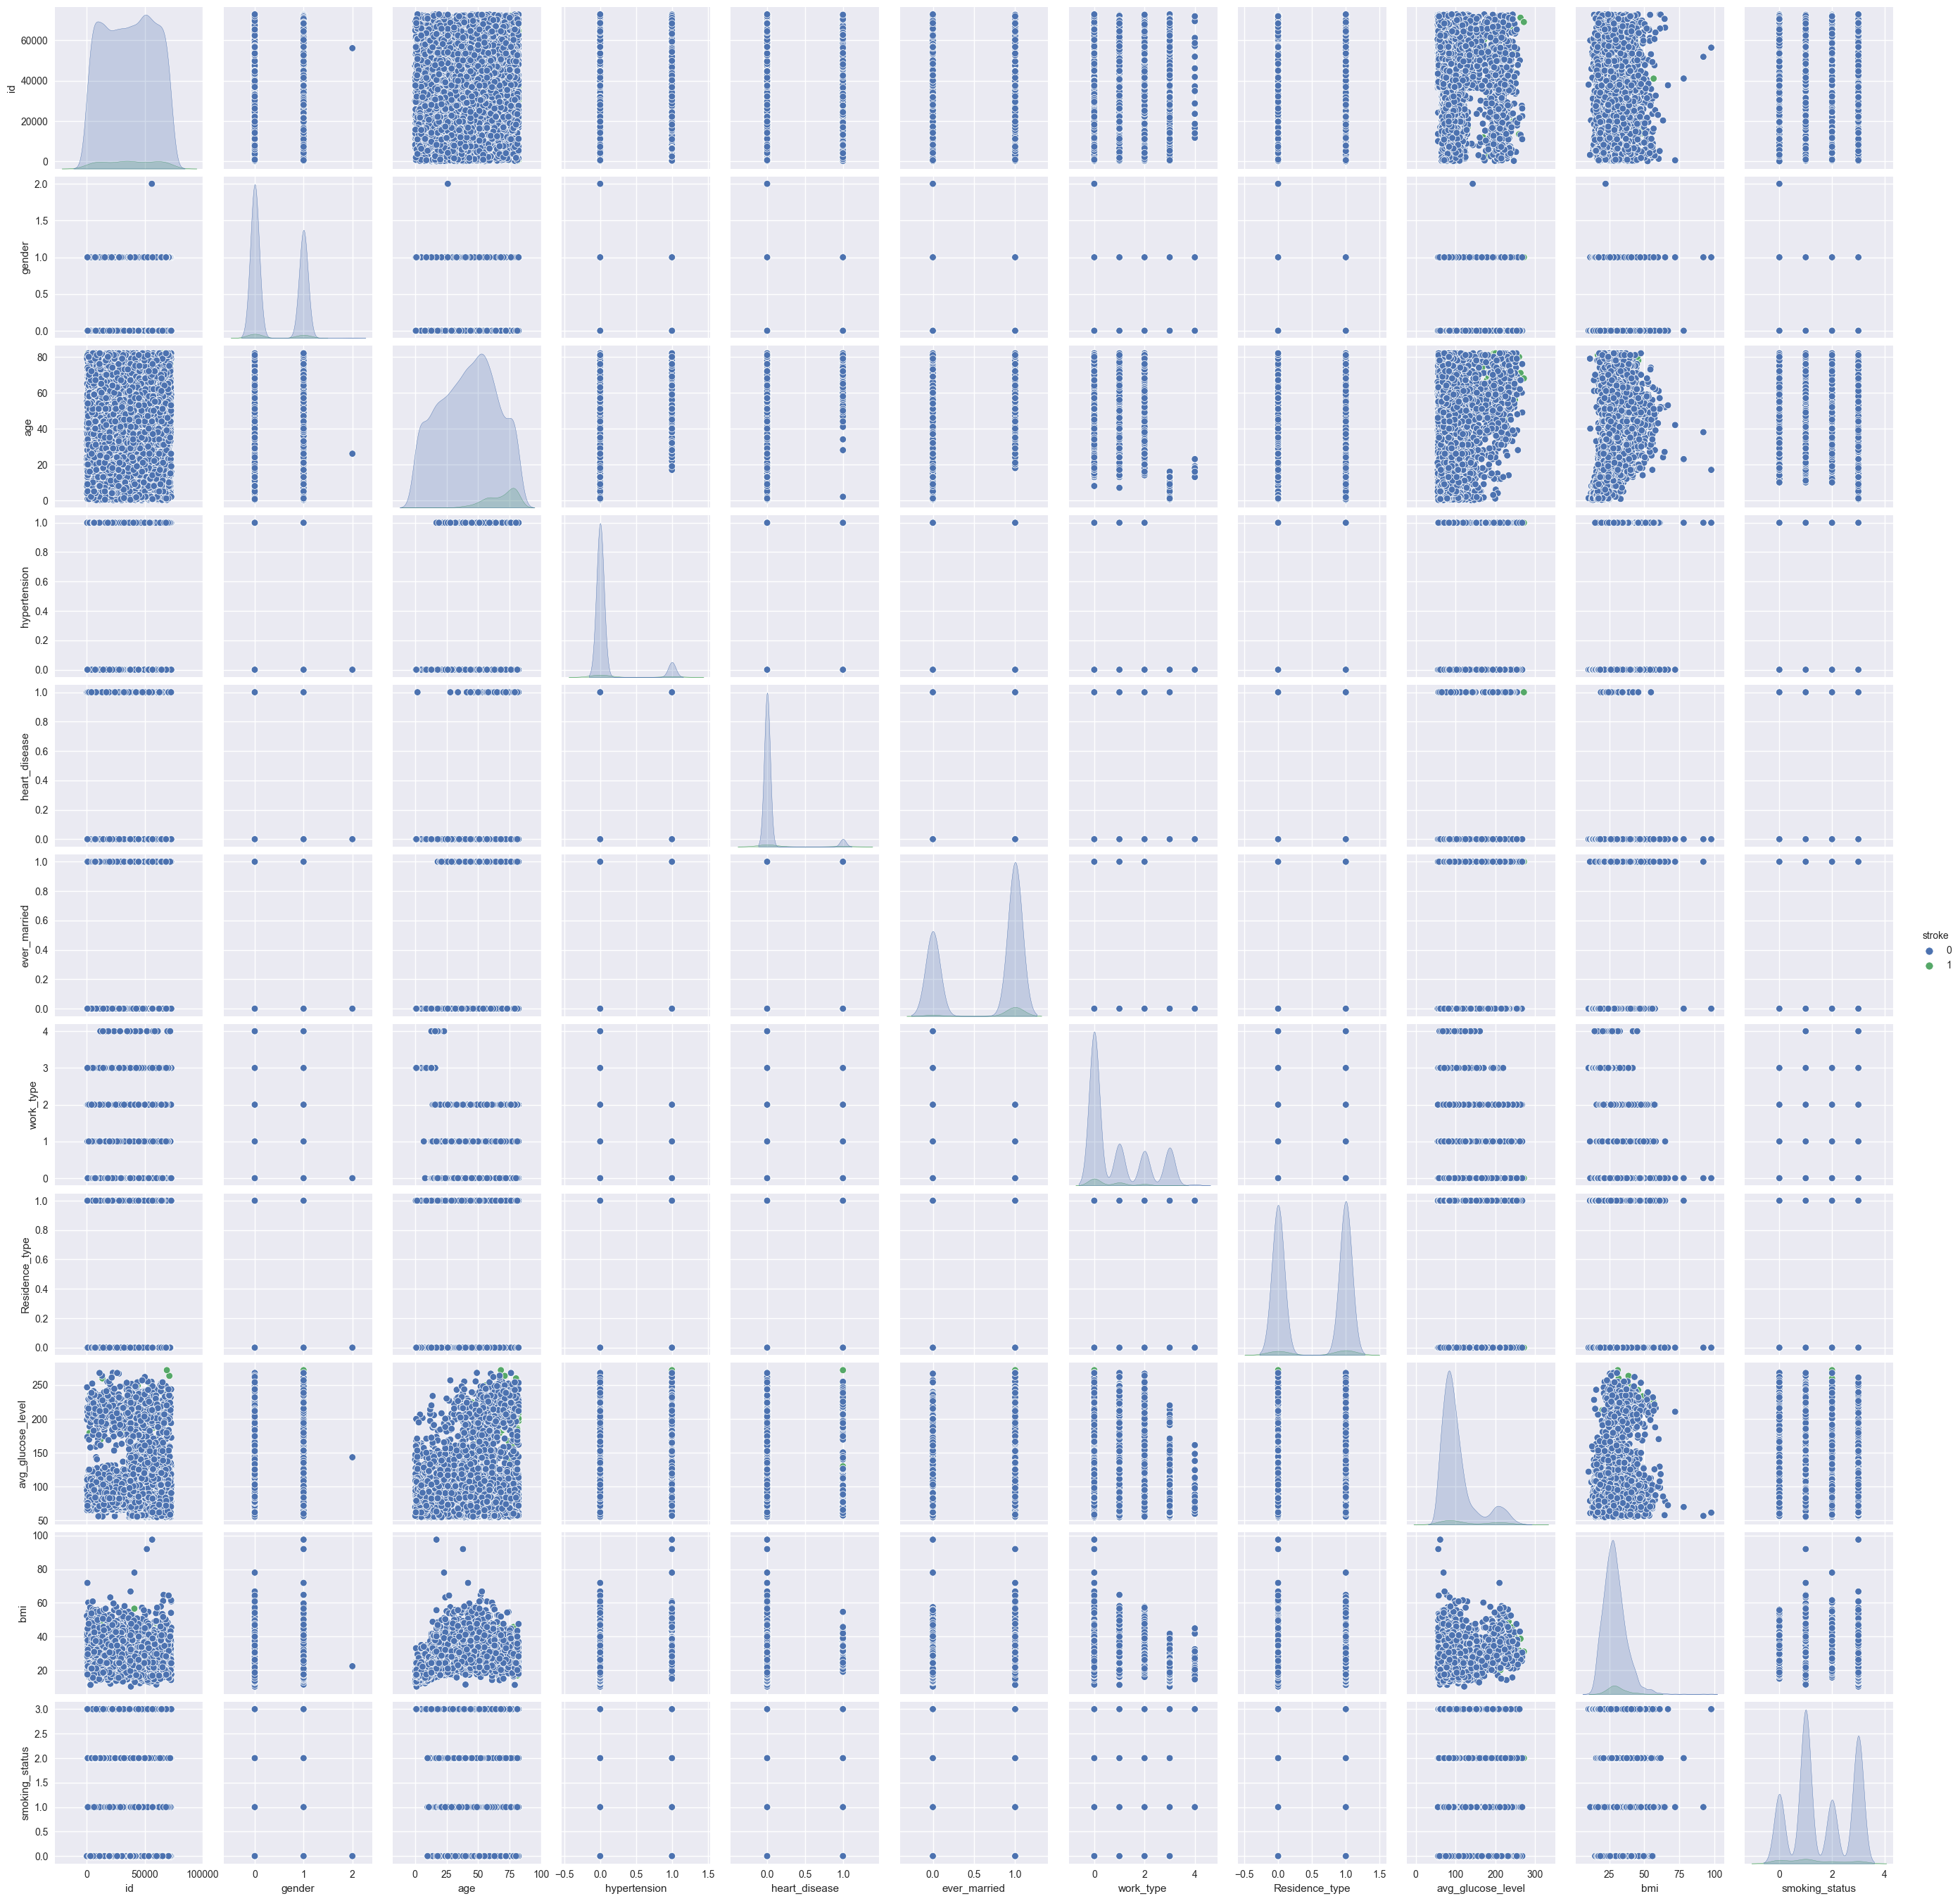

In [46]:
sns.pairplot(df_raw, hue='stroke')

Text(0.5, 1.0, 'Pearson correlation')

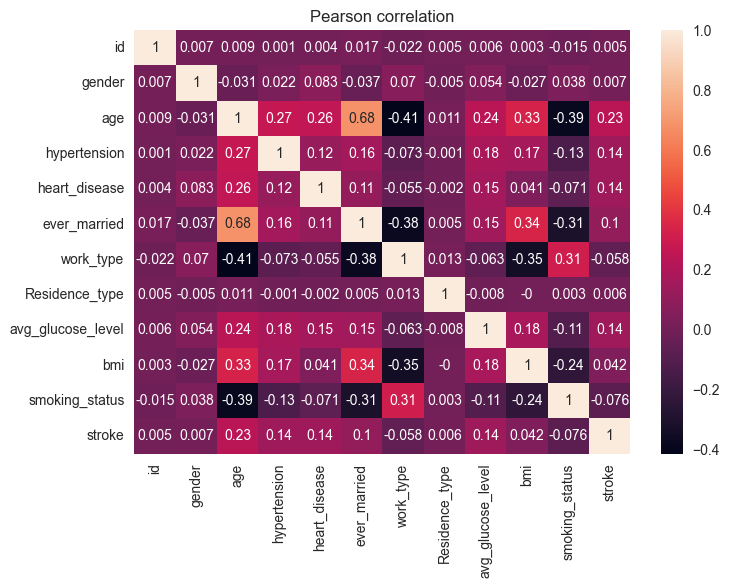

In [123]:
# make correlation plot
corr = df.corr("pearson").round(3)
sns.heatmap(corr, annot=True)
plt.title("Pearson correlation")

# Dealing with data imbalance

In [ ]:
# Under sampling: Remove instance  from the overrepresented class (randomly)
# Over sampling: SMOTE (Synthetic Minority Over-sampling Technique)
# Use a weighted loss function (assign higher weights to minority class)
# Ensemble methods (Random Forest, XGBoost, etc.) are naturally robust to imbalanced data

# create more features to help the model better predict stroke

In [ ]:
# use SVM to classify stroke
from sklearn.svm import SVC


<AxesSubplot: xlabel='age', ylabel='avg_glucose_level'>

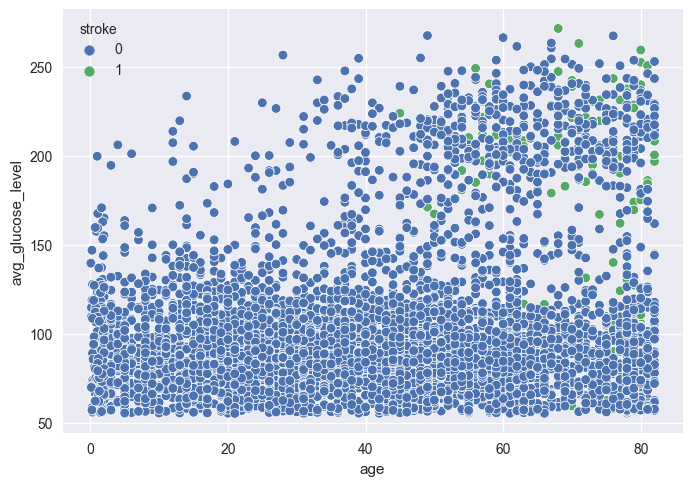

In [94]:
# make a scatter plot with seaborn
sns.scatterplot(data=df, x="age", y="avg_glucose_level", hue="stroke")

In [105]:
df[df['age'] < 30]['stroke'].value_counts()

0    1513
1       2
Name: stroke, dtype: int64

# Model Training

In [217]:
# Encode categorical variables as numbers
def encode_numericals(df: pd.DataFrame) -> pd.DataFrame:
    df_return = df.copy()
    df_return['ever_married'] = df_return['ever_married'].replace({'Yes': 1, 'No': 0})
    df_return['work_type'] = df_return['work_type'].replace({'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4})
    df_return['Residence_type'] = df_return['Residence_type'].replace({'Urban': 1, 'Rural': 0})
    df_return['smoking_status'] = df_return['smoking_status'].replace({'formerly smoked': 0, 'never smoked': 1, 'smokes': 2, 'Unknown': 3})
    df_return['gender'] = df_return['gender'].replace({"Female": 0, "Male": 1, "Other": 2})
    return df_return

df_processed = encode_numericals(df_raw)

In [218]:
# one hot encoding
categorical_variables = ['gender','work_type', 'smoking_status']
df_processed = pd.get_dummies(df_processed, columns=categorical_variables, drop_first=True)
df_processed.head()

,id,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,gender_1,gender_2,work_type_1,work_type_2,work_type_3,work_type_4,smoking_status_1,smoking_status_2,smoking_status_3
0,9046,67.0,0,1,1,1,228.69,36.6,1,1,0,0,0,0,0,0,0,0
1,51676,61.0,0,0,1,0,202.21,NaN,1,0,0,1,0,0,0,1,0,0
2,31112,80.0,0,1,1,0,105.92,32.5,1,1,0,0,0,0,0,1,0,0
3,60182,49.0,0,0,1,1,171.23,34.4,1,0,0,0,0,0,0,0,1,0
4,1665,79.0,1,0,1,0,174.12,24.0,1,0,0,1,0,0,0,1,0,0


In [219]:
# imputing missing values for BMI using KNN
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_processed['bmi'] = imputer.fit_transform(df_raw[['bmi']])

In [220]:
# feature normalisation for numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_processed[['age','avg_glucose_level', 'bmi']] = scaler.fit_transform(df_processed[['age', 'avg_glucose_level', 'bmi']])

In [222]:

# split the data into train and test sets
from sklearn.model_selection import train_test_split

def train_model(dataset, split_ratio: float = 0.2):
    X = dataset.drop(columns=['stroke'])
    y = dataset['stroke']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_ratio)

    # fit a random forest classifier
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    # make predictions
    y_pred = clf.predict(X_test)

    # evaluate the model
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
    print(accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

train_model(df_processed)

0.9461839530332681
[[967   1]
 [ 54   0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       968
           1       0.00      0.00      0.00        54

    accuracy                           0.95      1022
   macro avg       0.47      0.50      0.49      1022
weighted avg       0.90      0.95      0.92      1022

